In [1]:
import numpy as np
import torch
import os
import skimage.io as io
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch import from_numpy as from_numpy
from matplotlib.colors import ListedColormap
from active_learning_utils import process_images,load_obj,save_obj
import pickle

import sys
sys.path.append('../')  # 将上一层目录添加到模块搜索路径中
from func.model_arch2 import SegAirwayModel

/home/wangc/anaconda3/envs/test1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dict_org=load_obj('/home/wangc/now/NaviAirway/saved_objs/for_256_objs/data_dict_org.pkl')
data_dict_org['EXACT09_CASE02_0']

{'image': '/mnt/wangc/EXACT09/Precrop_dataset_for_EXACT09_256/image/EXACT09_CASE02_0.nii.gz',
 'label': '/mnt/wangc/EXACT09/Precrop_dataset_for_EXACT09_256/label/EXACT09_CASE02_0.nii.gz'}

In [2]:
# from active_learning_utils import show_all_2d_img_with_labels

# lidc2_img_path='/mnt/wangc/LIDC/image'
# output_f='/home/wangc/now/cluster_folder/lidc2'
# label_path='/mnt/wangc/LIDC/label'
# show_all_2d_img_with_labels(raw_img_path=lidc2_img_path, output_folder=output_f, img_num=None, 
#                                 num_images_per_batch=16, slice_index=20, label_path=label_path,raw_img_list=None)

## 导入数据集路径

In [3]:

Precrop_dataset_for_train_path = "/mnt/wangc/EXACT09/Precrop_dataset_for_EXACT09_128"
Precrop_dataset_for_train_raw_path = Precrop_dataset_for_train_path+"/image"
Precrop_dataset_for_train_label_path = Precrop_dataset_for_train_path+"/label"

raw_case_name_list = os.listdir(Precrop_dataset_for_train_raw_path)
print(len(raw_case_name_list))

lidc_dataset_for_train_path='/mnt/wangc/LIDC/Precrop_dataset_for_LIDC-IDRI_128'
lidc_dataset_for_train_raw_path =lidc_dataset_for_train_path+"/image"
lidc_dataset_for_train_label_path = lidc_dataset_for_train_path+"/label"
lidc_raw_case_name_list = os.listdir(lidc_dataset_for_train_raw_path)
print(len(lidc_raw_case_name_list))

8832
21760


## 使用预训练的权重得到数据样本的特征表示，并保存
如果已经保存，就不需要允许这一步，直接导入即可

In [6]:


device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
model=SegAirwayModel(in_channels=1, out_channels=2)
model.to(device)
load_pkl='/home/wangc/now/NaviAirway/checkpoint/abc_checkpoint_sample_org_33.pkl'
checkpoint = torch.load(load_pkl)
model.load_state_dict(checkpoint['model_state_dict'])

# embeddings_list, embeddings_dict=process_images(Precrop_dataset_for_train_path,
#                                                 raw_case_name_list, N=8832,model=model, device=device,
#                                                 only_positive=False)

<All keys matched successfully>

## 导入特征表示

In [7]:
file_path1='/home/wangc/now/NaviAirway/saved_var/exact09_128_op_embeddings_data.pkl'
file_path2='/home/wangc/now/NaviAirway/saved_var/lidc_128_op_embeddings_data.pkl'
with open(file_path1, 'rb') as file:
    loaded_data = pickle.load(file)
    exact_embeddings_list = loaded_data['embeddings_list']
    exact_embeddings_dict = loaded_data['embeddings_dict']
exact_stacked_embeddings_numpy = np.stack(exact_embeddings_list, axis=0)

with open(file_path2, 'rb') as file:
    loaded_data = pickle.load(file)
    lidc_embeddings_list = loaded_data['embeddings_list']
    lidc_embeddings_dict = loaded_data['embeddings_dict']
lidc_stacked_embeddings_numpy = np.stack(lidc_embeddings_list, axis=0)

## 将验证集剔除

In [10]:
test_names = ['LIDC_IDRI_0066', 'LIDC_IDRI_0328', 'LIDC_IDRI_0376',
'LIDC_IDRI_0441', 'EXACT09_CASE13', 'LIDC_IDRI_0744', 'LIDC_IDRI_1004',
'EXACT09_CASE08', 'EXACT09_CASE01', 'EXACT09_CASE05']
i=0
new_list=[]
new_dict={}
for key,v in exact_embeddings_dict.items():
    # print(key[:14])

    if key[:14] not in test_names:
        new_list.append(exact_embeddings_list[i])
        new_dict[key]=exact_embeddings_dict[key]
    i+=1
exact_embeddings_list=new_list
exact_embeddings_dict=new_dict

i=0
new_list=[]
new_dict={}
for key,v in lidc_embeddings_dict.items():
    if key[:14] not in test_names:
        new_list.append(lidc_embeddings_list[i])
        new_dict[key]=lidc_embeddings_dict[key]
    i+=1
lidc_embeddings_list=new_list
lidc_embeddings_dict=new_dict

## 合并exact09和lidc数据集

In [11]:
exact_stacked_embeddings_numpy = np.stack(exact_embeddings_list, axis=0)
lidc_stacked_embeddings_numpy = np.stack(lidc_embeddings_list, axis=0)

exact_lidc_concatenated_array = np.concatenate((exact_stacked_embeddings_numpy, lidc_stacked_embeddings_numpy), axis=0)
merged_dict={**exact_embeddings_dict,**lidc_embeddings_dict}
merged_list=raw_case_name_list+lidc_raw_case_name_list
exact_stacked_embeddings_numpy.shape,lidc_stacked_embeddings_numpy.shape,exact_lidc_concatenated_array.shape


((1976, 1, 256, 4, 16, 16),
 (5150, 1, 256, 4, 16, 16),
 (7126, 1, 256, 4, 16, 16))

## 初始化聚类中心

In [14]:
from active_learning_utils import kmeans
data_shape = exact_lidc_concatenated_array.shape

X_t = exact_lidc_concatenated_array.reshape(data_shape[0], -1)
# X_t=X_t[:200]
device2 = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

xi=[('e', 3, 166),
 ('e', 2, 55),
 ('e', 7, 162), 
 ('e', 4, 282),
 ('e', 9, 106), 
 ('l', 403, 93), 
 ('l', 140,295), 
 ('l', 438, 362), 
 ('l', 438, 477), 
 ('l', 529, 283)]



cu=[('e', 3, 418), 
 ('e', 2, 430),
 ('e', 2, 603),
 ('e', 7, 347),
 ('l', 438, 547),
 ('l', 529, 475),
 ('l', 140, 418),
 ('l', 403, 98), 
 ('l', 403, 228),
 ('l', 438, 612)]



def query_embedding(embeddings_dict, prefix,case_number, patch_number):
    if case_number < 10:
        case_number='0'+str(case_number)
    elif 20<case_number<100:
        case_number='0'+str(case_number)
    # if patch_number < 10:
    #     patch_number='0'+str(patch_number)
    query = prefix+str(case_number)+'_'+str(patch_number)+'.nii.gz'
    # print(query)
    return embeddings_dict[query],query

query_index={'e':'EXACT09_CASE','l':'LIDC_IDRI_0'}


# 生成查询并存储在列表中
query_list1 = []
query_list2 = []
query_list3 = []


three_tuple1=xi[0]    

emb_vector,_=query_embedding(merged_dict,query_index[three_tuple1[0]],three_tuple1[1],three_tuple1[2])

emb_vectors1=np.zeros((10, *emb_vector.shape))
emb_vectors2=np.zeros((10, *emb_vector.shape))
# emb_vectors3=np.zeros((10, *emb_vector.shape))

for i in range(10):

    emb_vector1, query1 = query_embedding(merged_dict, query_index[xi[i][0]],xi[i][1], xi[i][2])
    emb_vector2, query2 = query_embedding(merged_dict, query_index[cu[i][0]],cu[i][1], cu[i][2])

    emb_vectors1[i,:]=emb_vector1
    query_list1.append(query1)

    emb_vectors2[i,:]=emb_vector2
    query_list2.append(query2)


emb_vectors1_mean=emb_vectors1.mean(axis=0)
emb_vectors2_mean=emb_vectors2.mean(axis=0)
center_samples = np.concatenate([emb_vectors1_mean, emb_vectors2_mean], axis=0)
initial_centers = center_samples.reshape(2, -1)



X_t=from_numpy(X_t).float().to(device2)
initial_centers =from_numpy(initial_centers).float().to(device2)


KeyError: 'EXACT09_CASE02_55.nii.gz'

## 进行kmeans聚类

In [12]:
from active_learning_utils import kmeans
num_cluster=2
print('正在处理'+str(num_cluster))

cluster_labels, cluster_centers = kmeans(
    X=X_t, num_clusters=num_cluster, init=initial_centers,distance='euclidean', device=device2
)
cluster_labels = cluster_labels.cpu()


# print(X_t[0].shape)



# 将torch.Tensor转换为NumPy数组
X_t_with_labels = np.column_stack((X_t.cpu().numpy(), cluster_labels.reshape(-1, 1)))

# X_t_with_labels = np.column_stack((X_t, cluster_labels.reshape(-1, 1)))

N=X_t.shape[0]
# 使用 perplexity 为 50 的 t-SNE 进行嵌入
tsne = TSNE(n_components=2, perplexity=70)
X_embedded_2d = tsne.fit_transform(X_t_with_labels)
embedding_dict = {merged_list[i]: X_embedded_2d[i] for i in range(N)}
# center1,center2=cluster_centers[0],cluster_centers[1]




# 使用 t-SNE 进行降维
threshold_dim1 = 20000  # 调整阈值
threshold_dim2 = 20000  # 调整阈值

# 筛选出维度值在一定范围内的数据
filtered_indices = np.where((abs(X_embedded_2d[:, 0]) < threshold_dim1) & (abs(X_embedded_2d[:, 1]) < threshold_dim2))[0]

# 筛选出符合阈值的数据
filtered_embeddings = X_embedded_2d[filtered_indices]


正在处理2
running k-means on cuda:6..
torch.Size([2, 262144])


[running kmeans]: 0it [00:00, ?it/s]

[running kmeans]: 7it [00:03,  2.13it/s, center_shift=0.000000, iteration=7, tol=0.000100]    


In [15]:
X_t.shape,cluster_centers.shape,type(X_t)

(torch.Size([200, 262144]), torch.Size([2, 262144]), torch.Tensor)

## 计算距离

In [16]:
import torch

# 假设 X_t 和 cluster_centers 是你的数据
X_t = torch.randn(200, 262144)
cluster_centers = torch.randn(2, 262144)

# 扩展维度，使其能够进行广播
X_t_expanded = X_t.unsqueeze(1)  # 维度变为 (200, 1, 262144)
cluster_centers_expanded = cluster_centers.unsqueeze(0)  # 维度变为 (1, 2, 262144)

# 计算欧式距离
distances = torch.sqrt(torch.sum((X_t_expanded - cluster_centers_expanded) ** 2, dim=2))

print(distances.shape)  # 输出 torch.Size([200, 2])


torch.Size([200, 2])


In [18]:
distances

tensor([[724.3080, 724.7687],
        [723.9717, 723.5324],
        [724.9356, 723.1561],
        [724.0825, 724.3384],
        [725.1298, 725.2874],
        [725.6386, 725.5818],
        [723.6379, 723.7122],
        [722.7226, 723.7032],
        [723.5927, 724.6440],
        [723.7064, 724.2050],
        [724.0501, 723.6964],
        [723.9477, 725.1171],
        [724.0898, 725.3372],
        [724.2075, 724.0349],
        [724.4951, 724.3516],
        [723.8867, 725.0637],
        [724.3505, 725.2668],
        [723.6740, 725.7797],
        [724.5701, 724.4973],
        [725.2748, 724.9883],
        [723.9863, 724.3676],
        [725.9589, 725.1064],
        [724.4642, 725.4367],
        [726.2970, 725.3194],
        [724.1252, 723.6758],
        [725.0089, 724.0546],
        [724.2704, 724.3494],
        [723.8616, 724.6359],
        [724.6244, 722.8103],
        [725.0084, 723.2629],
        [725.0366, 725.5848],
        [724.6779, 724.6428],
        [722.1723, 723.3610],
        [7

In [7]:
cluster_dict=load_obj('/home/wangc/now/NaviAirway/saved_objs/indices.pkl')

In [8]:
from active_learning_utils import show_all_2d_img_with_labels
result_2=cluster_dict[2]
a_class=result_2['class_0']
exact_sample,lidc_sample=[],[]
for name in a_class:
    if name[:3] =='EXA':
        exact_sample.append(name)
    if name[:3] =='LID':
        lidc_sample.append(name)
print(len(lidc_sample)+len(exact_sample)==len(a_class))
show_all_2d_img_with_labels(raw_img_path=Precrop_dataset_for_train_raw_path , output_folder='/home/wangc/now/NaviAirway/saved_picture/cluster_2/class1', img_num=200, 
                                num_images_per_batch=16, slice_index=20, label_path=Precrop_dataset_for_train_label_path ,raw_img_list=exact_sample,file_name='EXACT09')
show_all_2d_img_with_labels(raw_img_path=lidc_dataset_for_train_raw_path , output_folder='/home/wangc/now/NaviAirway/saved_picture/cluster_2/class1', img_num=200, 
                                num_images_per_batch=16, slice_index=20, label_path=lidc_dataset_for_train_label_path ,raw_img_list=lidc_sample,file_name='LIDC')


True


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/mnt/wangc/LIDC/Precrop_dataset_for_LIDC-IDRI_256/image/EXACT09_CASE01_1.nii.gz" does not exist.

In [22]:
def show_all_2d_img_with_labels(raw_img_path, output_folder, img_num=None, 
                                num_images_per_batch=16, slice_index=20, label_path=None,raw_img_list=None,file_name='no_name'):
    if raw_img_list is None:
        raw_img_list = os.listdir(raw_img_path)
    if img_num is None:
        img_num = len(raw_img_list)
    img_num = min(img_num, len(raw_img_list))
    num_batches = (img_num + num_images_per_batch - 1) // num_images_per_batch  # 上取整

    num_rows = 4
    num_cols = 4
    
    # 检查并创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for batch_num in range(num_batches):
        start_index = batch_num * num_images_per_batch
        end_index = min((batch_num + 1) * num_images_per_batch, img_num)
        
        img_list = []
        label_list = []  # 新增：用于存储标签图像

        img_names=[]
        label_names=[]
        
        for i in range(start_index, end_index):
            raw_img_addr = os.path.join(raw_img_path, raw_img_list[i])
            raw_img = io.imread(raw_img_addr, plugin='simpleitk')
            img_list.append(raw_img)

            img_names.append(raw_img_list[i])
            
            if label_path is not None:
                if raw_img_list is None:
                    label_img_list = os.listdir(label_path)
                else:
                    label_img_list=raw_img_list
                label_img_addr = os.path.join(label_path, label_img_list[i])  # 使用相同的索引加载标签图像
                label_img = io.imread(label_img_addr, plugin='simpleitk')
                label_list.append(label_img)  # 存储标签图像

                label_names.append(label_img_list[i])
        
        # 创建一个包含16个子图的图像窗口，使用gridspec布局
        fig = plt.figure(figsize=(20, 20))
        gs = gridspec.GridSpec(num_rows, num_cols, figure=fig)
        fig.suptitle(f"Batch {batch_num+1} - Raw Images")
        for i in range(num_rows):
            for j in range(num_cols):
                index = i * num_cols + j
                if index < len(img_list):
                    raw_img = img_list[index]
                    ax = fig.add_subplot(gs[i, j])
                    if label_path is not None:
                        label_img = label_list[index]  # 使用相应索引的标签图像
                        if 1 not in label_img[slice_index, :, :]:
                            p=0
                            while(p<label_img.shape[0] and 1 not in label_img[p, :, :]):
                                p+=1
                            if p<label_img.shape[0]:
                                ax.imshow(raw_img[p, :, :], cmap='gray')
                                ax.contour(label_img[p, :, :], colors='r', linestyles='-')
                            else:
                                p=0
                                ax.imshow(raw_img[p, :, :], cmap='gray')
                                ax.contour(label_img[p, :, :], colors='r', linestyles='-')
                                ax.text(1, 1, 'No Label', color='red', fontsize=16, ha='right', va='top', transform=ax.transAxes)
                        else:
                            p=slice_index
                            ax.imshow(raw_img[p, :, :], cmap='gray')
                            ax.contour(label_img[p, :, :], colors='r', linestyles='-')
                    else:
                        p=slice_index
                        ax.imshow(raw_img[p, :, :], cmap='gray')
                    ax.set_title(f"{p} Image {img_names[index]}\nLabel {label_names[index]} ")
                    ax.axis('off')
               
        # 调整子图之间的间距和布局
        plt.tight_layout()
        
        # 保存图像
        plt.savefig(os.path.join(output_folder, f"{file_name}_cluster_{batch_num+1}.png"))
        
        # 关闭图像窗口，避免重叠
        plt.close()

In [1]:
import numpy as np
import torch
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"
import skimage.io as io
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch import from_numpy as from_numpy
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

from active_learning_utils import process_images,visualize_and_return_indices,show_all_2d_img_with_labels,kmeans,save_obj,load_obj
import pickle

import sys
sys.path.append('../')  # 将上一层目录添加到模块搜索路径中
from func.model_arch2 import SegAirwayModel

import torch.utils.data as data_utils


import edt


import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data.distributed import DistributedSampler


# 设置分布式环境
# local_rank = int(os.environ.get("LOCAL_RANK", 0))



print(2342334)
crop_size=['128','256']
file_insert=crop_size[0]
Precrop_dataset_for_train_path = f"/mnt/wangc/EXACT09/Precrop_dataset_for_EXACT09_{file_insert}"
Precrop_dataset_for_train_raw_path = Precrop_dataset_for_train_path+"/image"
Precrop_dataset_for_train_label_path = Precrop_dataset_for_train_path+"/label"

raw_case_name_list = os.listdir(Precrop_dataset_for_train_raw_path)
# print(len(raw_case_name_list))

lidc_dataset_for_train_path=f'/mnt/wangc/LIDC/Precrop_dataset_for_LIDC-IDRI_{file_insert}'
lidc_dataset_for_train_raw_path =lidc_dataset_for_train_path+"/image"
lidc_dataset_for_train_label_path = lidc_dataset_for_train_path+"/label"
lidc_raw_case_name_list = os.listdir(lidc_dataset_for_train_raw_path)
# print(len(lidc_raw_case_name_list))

print(2318)
# 从文件加载
# file_path1='/home/wangc/now/NaviAirway/saved_var/exact09_256_embeddings_data.pkl'
# file_path2='/home/wangc/now/NaviAirway/saved_var/lidc_256_embeddings_data.pkl'

file_path1=f'/home/wangc/now/NaviAirway/saved_var/exact09_{file_insert}_op_embeddings_data.pkl'
file_path2=f'/home/wangc/now/NaviAirway/saved_var/lidc_{file_insert}_op_embeddings_data.pkl'
with open(file_path1, 'rb') as file:
    loaded_data = pickle.load(file)
    exact_embeddings_list = loaded_data['embeddings_list']
    exact_embeddings_dict = loaded_data['embeddings_dict']
exact_stacked_embeddings_numpy = np.stack(exact_embeddings_list, axis=0)

with open(file_path2, 'rb') as file:
    loaded_data = pickle.load(file)
    lidc_embeddings_list = loaded_data['embeddings_list']
    lidc_embeddings_dict = loaded_data['embeddings_dict']
lidc_stacked_embeddings_numpy = np.stack(lidc_embeddings_list, axis=0)

print(2333)
test_names = ['LIDC_IDRI_0066', 'LIDC_IDRI_0328', 'LIDC_IDRI_0376',
'LIDC_IDRI_0441',  'LIDC_IDRI_0744', 'LIDC_IDRI_1004','EXACT09_CASE13',
'EXACT09_CASE08', 'EXACT09_CASE01', 'EXACT09_CASE05']

i=0
new_list=[]
new_dict={}
for key,v in exact_embeddings_dict.items():
    if key[:14] not in test_names:
        new_list.append(exact_embeddings_list[i])
        new_dict[key]=exact_embeddings_dict[key]
    i+=1
exact_embeddings_list=new_list
exact_embeddings_dict=new_dict

i=0
new_list=[]
new_dict={}
for key,v in lidc_embeddings_dict.items():
    if key[:14] not in test_names:
        new_list.append(lidc_embeddings_list[i])
        new_dict[key]=lidc_embeddings_dict[key]
    i+=1
lidc_embeddings_list=new_list
lidc_embeddings_dict=new_dict

print(2433)
exact_stacked_embeddings_numpy = np.stack(exact_embeddings_list, axis=0)
lidc_stacked_embeddings_numpy = np.stack(lidc_embeddings_list, axis=0)

exact_lidc_concatenated_array = np.concatenate((exact_stacked_embeddings_numpy, lidc_stacked_embeddings_numpy), axis=0)
merged_dict={**exact_embeddings_dict,**lidc_embeddings_dict}
merged_list=list(exact_embeddings_dict.keys())+list(lidc_embeddings_dict.keys())
print(exact_stacked_embeddings_numpy.shape,lidc_stacked_embeddings_numpy.shape,exact_lidc_concatenated_array.shape)



# exact_lidc_concatenated_array = np.concatenate((exact_stacked_embeddings_numpy, lidc_stacked_embeddings_numpy), axis=0)
# merged_dict={**exact_embeddings_dict,**lidc_embeddings_dict}
# merged_list=raw_case_name_list+lidc_raw_case_name_list






print(2566)
data_shape = exact_lidc_concatenated_array.shape

X_t = exact_lidc_concatenated_array.reshape(data_shape[0], -1)
device2 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device3 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')


print(X_t.shape)

/home/wangc/anaconda3/envs/test1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2342334
2318


In [5]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches  # Add this import statement


data_shape = exact_lidc_concatenated_array.shape

X_t = exact_lidc_concatenated_array.reshape(data_shape[0], -1)[:50]


# 创建 K 均值聚类模型并指定初始中心
# kmeans = KMeans(n_clusters=2, init=initial_centers, n_init=1, random_state=0)
kmeans = KMeans(n_clusters=2, random_state=0)
# 执行聚类
kmeans.fit(X_t)

# 获取聚类标签
cluster_labels = kmeans.labels_

# 将聚类结果添加到 X_t 中作为最后一列
X_t_with_labels = np.column_stack((X_t, cluster_labels.reshape(-1, 1)))

N=X_t.shape[0]



# # 使用 perplexity 为 50 的 t-SNE 进行嵌入
# tsne = TSNE(n_components=2, perplexity=70)
# X_embedded_2d = tsne.fit_transform(X_t_with_labels)
# embedding_dict = {merged_list[i]: X_embedded_2d[i] for i in range(N)}


# # 使用 t-SNE 进行降维
# threshold_dim1 = 20000  # 调整阈值
# threshold_dim2 = 20000  # 调整阈值

# # 筛选出维度值在一定范围内的数据
# filtered_indices = np.where((abs(X_embedded_2d[:, 0]) < threshold_dim1) & (abs(X_embedded_2d[:, 1]) < threshold_dim2))[0]

# # 筛选出符合阈值的数据
# filtered_embeddings = X_embedded_2d[filtered_indices]


# # 绘制二维散点图，只绘制符合阈值的数据
# # 可视化二维嵌入并根据聚类标签着色
# # colors = list(mcolors.TABLEAU_COLORS.values())
# # custom_cmap = mcolors.ListedColormap(colors)


# unique_labels = np.unique(cluster_labels)
# cmap = plt.get_cmap('viridis', len(unique_labels))
# colors = [cmap(i) for i in range(len(unique_labels))]

# # query1_points = [True if name in query_list1 else False for name in embeddings_dict.keys()]
# # query2_points = [True if name in query_list2 else False for name in embeddings_dict.keys()]
# # query3_points = [True if name in query_list3 else False for name in embeddings_dict.keys()]
# # # 使用 ListedColormap 为不同的聚类簇指定颜色

# custom_cmap = ListedColormap(colors)
# # 创建图例标签
# legend_labels = [f'class{label}' for label in np.unique(cluster_labels)]

# # 创建图例句柄
# legend_handles = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(unique_labels))]

# plt.figure(figsize=(8, 6), dpi=100)
# plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=cluster_labels[filtered_indices], cmap=custom_cmap)
# plt.title("t-SNE 2D Embedding with Cluster Coloring (Perplexity=70)")

# # 
# # 添加图例
# plt.legend(handles=legend_handles, loc='upper right')
# plt.show()


/home/wangc/anaconda3/envs/test1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:

X_t.shape

(50, 262144)

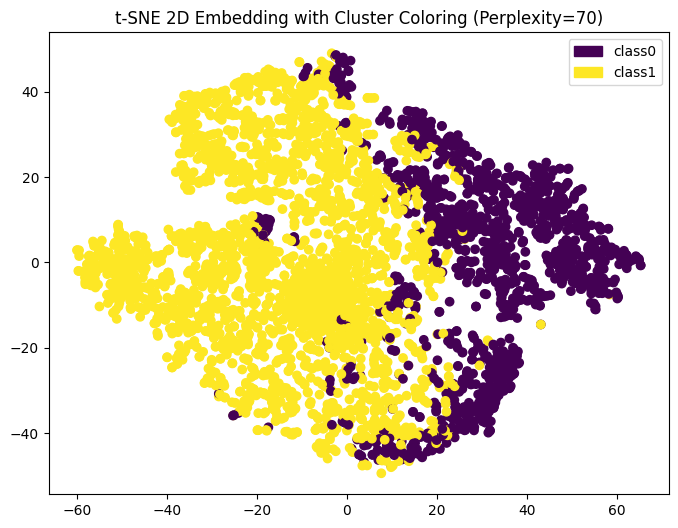

In [22]:
# 使用 t-SNE 进行降维
threshold_dim1 = 20000  # 调整阈值
threshold_dim2 = 20000  # 调整阈值

# 筛选出维度值在一定范围内的数据
filtered_indices = np.where((abs(X_embedded_2d[:, 0]) < threshold_dim1) & (abs(X_embedded_2d[:, 1]) < threshold_dim2))[0]

# 筛选出符合阈值的数据
filtered_embeddings = X_embedded_2d[filtered_indices]


# 绘制二维散点图，只绘制符合阈值的数据
# 可视化二维嵌入并根据聚类标签着色
# colors = list(mcolors.TABLEAU_COLORS.values())
# custom_cmap = mcolors.ListedColormap(colors)


unique_labels = np.unique(cluster_labels)
cmap = plt.get_cmap('viridis', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]

# query1_points = [True if name in query_list1 else False for name in embeddings_dict.keys()]
# query2_points = [True if name in query_list2 else False for name in embeddings_dict.keys()]
# query3_points = [True if name in query_list3 else False for name in embeddings_dict.keys()]
# # 使用 ListedColormap 为不同的聚类簇指定颜色

custom_cmap = ListedColormap(colors)
# 创建图例标签
legend_labels = [f'class{label}' for label in np.unique(cluster_labels)]

# 创建图例句柄
legend_handles = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(unique_labels))]

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=cluster_labels[filtered_indices], cmap=custom_cmap)
plt.title("t-SNE 2D Embedding with Cluster Coloring (Perplexity=70)")

# 
# 添加图例
plt.legend(handles=legend_handles, loc='upper right')
plt.show()


In [10]:
from kmeans_pytorch import kmeans, kmeans_predict#需要安装这个包
import torch.utils.data as data_utils

data_shape = exact_lidc_concatenated_array.shape

X_t = exact_lidc_concatenated_array.reshape(data_shape[0], -1)
X_t=X_t[:200]
device2 = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
X_tensor=from_numpy(X_t).float().to(device)
#需要把数据放到GPU上
num_clusters = 2
cluster_labels, cluster_centers = kmeans(
    X=X_tensor, num_clusters=num_clusters, distance='euclidean', device=device2
)

running k-means on cuda:3..


[running kmeans]: 11it [00:06,  1.65it/s, center_shift=0.000000, iteration=11, tol=0.000100]   


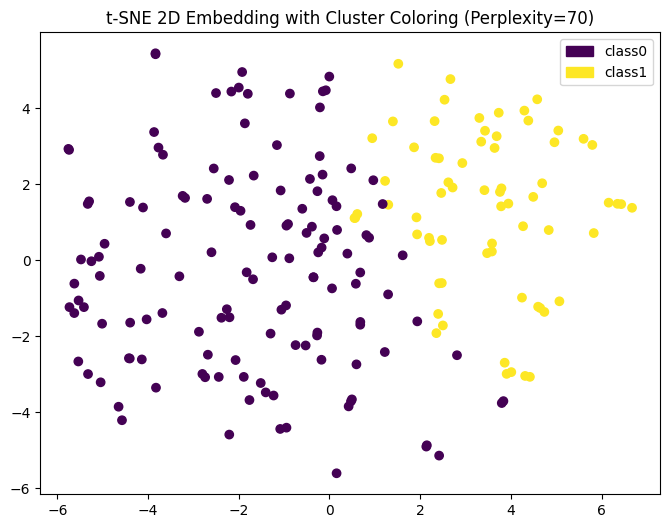

In [11]:
X_t_with_labels = np.column_stack((X_t, cluster_labels.reshape(-1, 1)))

N=X_t.shape[0]
# 使用 perplexity 为 50 的 t-SNE 进行嵌入
tsne = TSNE(n_components=2, perplexity=70)
X_embedded_2d = tsne.fit_transform(X_t_with_labels)
embedding_dict = {raw_case_name_list[i]: X_embedded_2d[i] for i in range(N)}

# 使用 t-SNE 进行降维
threshold_dim1 = 2000  # 调整阈值
threshold_dim2 = 2000  # 调整阈值

# 筛选出维度值在一定范围内的数据
filtered_indices = np.where((abs(X_embedded_2d[:, 0]) < threshold_dim1) & (abs(X_embedded_2d[:, 1]) < threshold_dim2))[0]

# 筛选出符合阈值的数据
filtered_embeddings = X_embedded_2d[filtered_indices]


# 绘制二维散点图，只绘制符合阈值的数据
# 可视化二维嵌入并根据聚类标签着色
# colors = list(mcolors.TABLEAU_COLORS.values())
# custom_cmap = mcolors.ListedColormap(colors)


unique_labels = np.unique(cluster_labels)
cmap = plt.get_cmap('viridis', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]


custom_cmap = ListedColormap(colors)
# 创建图例标签
legend_labels = [f'class{label}' for label in np.unique(cluster_labels)]

# 创建图例句柄
legend_handles = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(unique_labels))]

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=cluster_labels[filtered_indices], cmap=custom_cmap)
plt.title("t-SNE 2D Embedding with Cluster Coloring (Perplexity=70)")


# 添加图例
plt.legend(handles=legend_handles, loc='upper right')
plt.show()


In [ ]:
X_t_with_labels = np.column_stack((X_t, cluster_labels.reshape(-1, 1)))

N=X_t.shape[0]
# 使用 perplexity 为 50 的 t-SNE 进行嵌入
tsne = TSNE(n_components=2, perplexity=70)
X_embedded_2d = tsne.fit_transform(X_t_with_labels)
embedding_dict = {merged_list[i]: X_embedded_2d[i] for i in range(N)}




In [64]:
emb_vectors1_mean=emb_vectors1.mean(axis=0)
emb_vectors2_mean=emb_vectors2.mean(axis=0)
emb_vectors3_mean=emb_vectors3.mean(axis=0)
emb_vectors1_mean.shape

(1, 256, 4, 16, 16)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches  # Add this import statement


# center_samples = np.concatenate([emb_vectors1_mean, emb_vectors2_mean, emb_vectors3_mean], axis=0)
center_samples = np.concatenate([emb_vectors1_mean, emb_vectors2_mean], axis=0)
# 要聚类的数据 stacked_embeddings_numpy 的形状
data_shape = stacked_embeddings_numpy.shape

X_t = stacked_embeddings_numpy.reshape(data_shape[0], -1)

# 预设3个样本中心
initial_centers = center_samples.reshape(2, -1)

# 创建 K 均值聚类模型并指定初始中心
kmeans = KMeans(n_clusters=2, init=initial_centers, n_init=1, random_state=0)
# kmeans = KMeans(n_clusters=2, random_state=0)
# 执行聚类
kmeans.fit(X_t)

# 获取聚类标签
cluster_labels = kmeans.labels_

# 将聚类结果添加到 X_t 中作为最后一列
X_t_with_labels = np.column_stack((X_t, cluster_labels.reshape(-1, 1)))

N=X_t.shape[0]
# 使用 perplexity 为 50 的 t-SNE 进行嵌入
tsne = TSNE(n_components=2, perplexity=70)
X_embedded_2d = tsne.fit_transform(X_t_with_labels)
embedding_dict = {raw_case_name_list[i]: X_embedded_2d[i] for i in range(N)}


# 使用 t-SNE 进行降维
threshold_dim1 = 20000  # 调整阈值
threshold_dim2 = 20000  # 调整阈值

# 筛选出维度值在一定范围内的数据
filtered_indices = np.where((abs(X_embedded_2d[:, 0]) < threshold_dim1) & (abs(X_embedded_2d[:, 1]) < threshold_dim2))[0]

# 筛选出符合阈值的数据
filtered_embeddings = X_embedded_2d[filtered_indices]


# 绘制二维散点图，只绘制符合阈值的数据
# 可视化二维嵌入并根据聚类标签着色
# colors = list(mcolors.TABLEAU_COLORS.values())
# custom_cmap = mcolors.ListedColormap(colors)


unique_labels = np.unique(cluster_labels)
cmap = plt.get_cmap('viridis', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]

query1_points = [True if name in query_list1 else False for name in embeddings_dict.keys()]
query2_points = [True if name in query_list2 else False for name in embeddings_dict.keys()]
query3_points = [True if name in query_list3 else False for name in embeddings_dict.keys()]
# 使用 ListedColormap 为不同的聚类簇指定颜色

custom_cmap = ListedColormap(colors)
# 创建图例标签
legend_labels = [f'class{label}' for label in np.unique(cluster_labels)]

# 创建图例句柄
legend_handles = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(unique_labels))]

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=cluster_labels[filtered_indices], cmap=custom_cmap)
plt.title("t-SNE 2D Embedding with Cluster Coloring (Perplexity=70)")

m1=0
m2=0
# 添加大黑点和标记
for i in range(len(filtered_embeddings)):
    if query1_points[filtered_indices[i]] is True:
        m1+=1
        plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='red', s=150, marker='o', label='query_list1') 
    if query2_points[filtered_indices[i]] is True:
        m2+=1
        plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='pink', s=150, marker='o', label='query_list2') 
    # if query3_points[filtered_indices[i]] is True:
    #     plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='orange', s=150, marker='o', label='query_list3')  


# 添加图例
plt.legend(handles=legend_handles, loc='upper right')
plt.show()


In [11]:
#类KNN方式1 进行聚类
# 1. 先给出   A 10 样本:a1,a2,...,a10 对应1 
#             B 10 样本:b1,b2,...,b10 对应2
#             C 10 样本:c1,c2,...,c10 对应3
# 2. 对于A中点ai,计算ai的一个邻域内的点:
#     (1)根据距离函数和半径d，得到ai一个圆内的坐标，
#     (2)将Data中坐标在其中的点找出来，得到m1,m2,...,mn
# 3. 将所有mi的标签设为1
# 4. 同理对B、C的点做 2,3
def assign_labels_within_radius(data, labeled_dict, radius):
    # 初始化一个数组用于存储分配标签后的结果
    labels = np.full(len(data), -1, dtype=int)

    for label,value in labeled_dict.items():
        for i in range(value.shape[0]):
            point = emb_vectors1[i].reshape(1,-1)
            # 计算点point的邻域内的点
            neighbors_indices = [j for j in range(len(data.shape[0])) if np.linalg.norm(point - data[j]) <= radius]
            print(point - data[j])
        # 将邻域内的点的标签设为与当前点相同的标签
            for neighbor_index in neighbors_indices:
                labels[neighbor_index] = label

    return labels


In [12]:


#类KNN方式2 进行聚类
# 1. 先给出   A 10 样本:a1,a2,...,a10 对应1 
#             B 10 样本:b1,b2,...,b10 对应2
#             C 10 样本:c1,c2,...,c10 对应3

# 2. 对于data中任何一个点p
    # 计算 和A10个点距离da1,da2,...,da10 DA
    # db1,db2,...,db10 DB
    # dc1,dc2,...,dc10 DC 
    # 取最小值所在的类作为p的类




import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches  # Add this import statement
def cosine_similarity(tensor1, tensor2):
    flat_tensor1 = tensor1.flatten()
    flat_tensor2 = tensor2.flatten()
    
    dot_product = np.dot(flat_tensor1, flat_tensor2)
    norm_flat_tensor1 = np.linalg.norm(flat_tensor1)
    norm_flat_tensor2 = np.linalg.norm(flat_tensor2)
    
    similarity = dot_product / (norm_flat_tensor1 * norm_flat_tensor2)
    return similarity
def cosine_distance(tensor1, tensor2):
    flat_tensor1 = tensor1.flatten()
    flat_tensor2 = tensor2.flatten()
    
    dot_product = np.dot(flat_tensor1, flat_tensor2)
    norm_flat_tensor1 = np.linalg.norm(flat_tensor1)
    norm_flat_tensor2 = np.linalg.norm(flat_tensor2)
    
    similarity = dot_product / (norm_flat_tensor1 * norm_flat_tensor2)
    dist=1-similarity
    return dist
def custom_euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)
def assign_labels_within_radius(data, labeled_dict,distance_func=custom_euclidean_distance):
    # 初始化一个数组用于存储分配标签后的结果

    labels = np.full(len(data),-1, dtype=int)
    distance_statistics=[]
    for i in range(data.shape[0]):
        dis={}
        pre_distance = float('inf')
        for label,points in labeled_dict.items():
            points_reshape=points.reshape(points.shape[0],-1)
            distance_sum=0
            for point in points_reshape:
                distance_sum+=distance_func(point,data[i])
            if distance_sum<pre_distance:
                labels[i]=label 
            print(distance_sum)
            dis[label]=distance_sum


            pre_distance=distance_sum
        distance_statistics.append(dis)
        print(f'this is {labels[i]},we are doing {i/data.shape[0]*100:.2f}%')
    return labels,distance_statistics




In [15]:
# labeled_dict={1:emb_vectors1,2:emb_vectors2,3:emb_vectors3}
#距离越大，应该离得越远
labeled_dict={0:emb_vectors1,1:emb_vectors2}

# 获取聚类标签
X_t=stacked_embeddings_numpy.reshape(stacked_embeddings_numpy.shape[0],-1)

cluster_labels,distance_statistics = assign_labels_within_radius(X_t, labeled_dict,distance_func=custom_euclidean_distance)




5362.217560193543
5538.7508363194665
this is 0,we are doing 0.00%
4914.788205352735
4880.386372471502
this is 1,we are doing 0.04%
4762.399568094835
4326.243573419823
this is 1,we are doing 0.08%
4195.275422551996
4268.577874002428
this is 0,we are doing 0.12%
4406.187123455908
4550.093429860951
this is 0,we are doing 0.16%
4317.624036742207
4578.28808762269
this is 0,we are doing 0.20%
4876.004106105633
4901.486138111294
this is 0,we are doing 0.25%
5152.806331312792
4914.564563268736
this is 1,we are doing 0.29%
5115.508447414285
4839.203466495879
this is 1,we are doing 0.33%
4932.218397805626
4766.449032059392
this is 1,we are doing 0.37%
4514.9238316663395
4171.7661398037435
this is 1,we are doing 0.41%
4764.209710515287
4419.549302691435
this is 1,we are doing 0.45%
4511.698800249517
4994.398404264358
this is 0,we are doing 0.49%
4548.967582909852
4615.871206649648
this is 0,we are doing 0.53%
4834.154896972595
4512.795246572174
this is 1,we are doing 0.57%
5265.153208964105
4788.

In [ ]:
X_t_with_labels = np.column_stack((X_t, cluster_labels.reshape(-1, 1)))

N=X_t.shape[0]
# 使用 perplexity 为 50 的 t-SNE 进行嵌入
tsne = TSNE(n_components=2, perplexity=70)
X_embedded_2d = tsne.fit_transform(X_t_with_labels)
embedding_dict = {raw_case_name_list[i]: X_embedded_2d[i] for i in range(N)}

# 使用 t-SNE 进行降维
threshold_dim1 = 2000  # 调整阈值
threshold_dim2 = 2000  # 调整阈值

# 筛选出维度值在一定范围内的数据
filtered_indices = np.where((abs(X_embedded_2d[:, 0]) < threshold_dim1) & (abs(X_embedded_2d[:, 1]) < threshold_dim2))[0]

# 筛选出符合阈值的数据
filtered_embeddings = X_embedded_2d[filtered_indices]


# 绘制二维散点图，只绘制符合阈值的数据
# 可视化二维嵌入并根据聚类标签着色
# colors = list(mcolors.TABLEAU_COLORS.values())
# custom_cmap = mcolors.ListedColormap(colors)


unique_labels = np.unique(cluster_labels)
cmap = plt.get_cmap('viridis', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]

query1_points = [True if name in query_list1 else False for name in embeddings_dict.keys()]
query2_points = [True if name in query_list2 else False for name in embeddings_dict.keys()]
query3_points = [True if name in query_list3 else False for name in embeddings_dict.keys()]
# 使用 ListedColormap 为不同的聚类簇指定颜色

custom_cmap = ListedColormap(colors)
# 创建图例标签
legend_labels = [f'class{label}' for label in np.unique(cluster_labels)]

# 创建图例句柄
legend_handles = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(unique_labels))]

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=cluster_labels[filtered_indices], cmap=custom_cmap)
plt.title("t-SNE 2D Embedding with Cluster Coloring (Perplexity=70)")

m1=0
m2=0

for i in range(len(filtered_embeddings)):
    if query1_points[filtered_indices[i]] is True:
        m1+=1
        plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='red', s=150, marker='o', label='query_list1') 
    if query2_points[filtered_indices[i]] is True:
        m2+=1
        plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='pink', s=150, marker='o', label='query_list2') 
    # if query3_points[filtered_indices[i]] is True:
    #     plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='orange', s=150, marker='o', label='query_list3')  


# 添加图例
plt.legend(handles=legend_handles, loc='upper right')
plt.show()


In [ ]:
unique_labels = np.unique(cluster_labels)
cmap = plt.get_cmap('viridis', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]

query1_points = [True if name in query_list1 else False for name in embeddings_dict.keys()]
query2_points = [True if name in query_list2 else False for name in embeddings_dict.keys()]
query3_points = [True if name in query_list3 else False for name in embeddings_dict.keys()]
# 使用 ListedColormap 为不同的聚类簇指定颜色

custom_cmap = ListedColormap(colors)
# 创建图例标签
legend_labels = [f'class{label}' for label in np.unique(cluster_labels)]

# 创建图例句柄
legend_handles = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(unique_labels))]

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=cluster_labels[filtered_indices], cmap=custom_cmap)
plt.title("t-SNE 2D Embedding with Cluster Coloring (Perplexity=70)")

m1=0
m2=0

# for i in range(len(filtered_embeddings)):
#     if query1_points[filtered_indices[i]] is True:
#         m1+=1
#         plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='red', s=150, marker='o', label='query_list1') 
#     if query2_points[filtered_indices[i]] is True:
#         m2+=1
#         plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='pink', s=150, marker='o', label='query_list2') 
#     # if query3_points[filtered_indices[i]] is True:
#     #     plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='orange', s=150, marker='o', label='query_list3')  


# 添加图例
plt.legend(handles=legend_handles, loc='upper right')
plt.show()

In [ ]:
# import numpy as np
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import matplotlib.patches as mpatches  # Add this import statement


# # center_samples = np.concatenate([emb_vectors1_mean, emb_vectors2_mean, emb_vectors3_mean], axis=0)
# center_samples = np.concatenate([emb_vectors1_mean, emb_vectors2_mean], axis=0)
# # 要聚类的数据 stacked_embeddings_numpy 的形状
# data_shape = stacked_embeddings_numpy.shape

# X_t = stacked_embeddings_numpy.reshape(data_shape[0], -1)

# # 预设3个样本中心
# initial_centers = center_samples.reshape(2, -1)

# # 创建 K 均值聚类模型并指定初始中心
# kmeans = KMeans(n_clusters=2, init=initial_centers, n_init=1, random_state=0)

# # 执行聚类
# kmeans.fit(X_t)

# # 获取聚类标签
# cluster_labels = kmeans.labels_

# # 将聚类结果添加到 X_t 中作为最后一列
# X_t_with_labels = np.column_stack((X_t, cluster_labels.reshape(-1, 1)))

# N=min(4000,X_t.shape[0])
# # 使用 perplexity 为 50 的 t-SNE 进行嵌入
# tsne = TSNE(n_components=2, perplexity=70)
# X_embedded_2d = tsne.fit_transform(X_t_with_labels)
# embedding_dict = {raw_case_name_list[i]: X_embedded_2d[i] for i in range(N)}


# # 使用 t-SNE 进行降维
# threshold_dim1 = 2000  # 调整阈值
# threshold_dim2 = 2000  # 调整阈值

# # 筛选出维度值在一定范围内的数据
# filtered_indices = np.where((abs(X_embedded_2d[:, 0]) < threshold_dim1) & (abs(X_embedded_2d[:, 1]) < threshold_dim2))[0]

# # 筛选出符合阈值的数据
# filtered_embeddings = X_embedded_2d[filtered_indices]


# # 绘制二维散点图，只绘制符合阈值的数据
# # 可视化二维嵌入并根据聚类标签着色
# # colors = list(mcolors.TABLEAU_COLORS.values())
# # custom_cmap = mcolors.ListedColormap(colors)


# unique_labels = np.unique(cluster_labels)
# cmap = plt.get_cmap('viridis', len(unique_labels))
# colors = [cmap(i) for i in range(len(unique_labels))]

# query1_points = [True if name in query_list1 else False for name in embeddings_dict.keys()]
# query2_points = [True if name in query_list2 else False for name in embeddings_dict.keys()]
# # query3_points = [True if name in query_list3 else False for name in embeddings_dict.keys()]
# # 使用 ListedColormap 为不同的聚类簇指定颜色

# custom_cmap = ListedColormap(colors)
# # 创建图例标签
# legend_labels = [f'class{label}' for label in np.unique(cluster_labels)]

# # 创建图例句柄
# legend_handles = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(unique_labels))]

# plt.figure(figsize=(8, 6), dpi=100)
# plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=cluster_labels[filtered_indices], cmap=custom_cmap)
# plt.title("t-SNE 2D Embedding with Cluster Coloring (Perplexity=70)")

# m1=0
# m2=0
# # 添加大黑点和标记
# for i in range(len(filtered_embeddings)):
#     if query1_points[filtered_indices[i]] is True:
#         m1+=1
#         plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='red', s=150, marker='o', label='query_list1') 
#     if query2_points[filtered_indices[i]] is True:
#         m2+=1
#         plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='pink', s=150, marker='o', label='query_list2') 
#     # if query3_points[filtered_indices[i]] is True:
#     #     plt.scatter(filtered_embeddings[i, 0], filtered_embeddings[i, 1], c='orange', s=150, marker='o', label='query_list3')  


# # 添加图例
# plt.legend(handles=legend_handles, loc='upper right')
# plt.show()

filtered_indices 200
filtered_embeddings.shape (200, 2)


<Figure size 640x480 with 0 Axes>

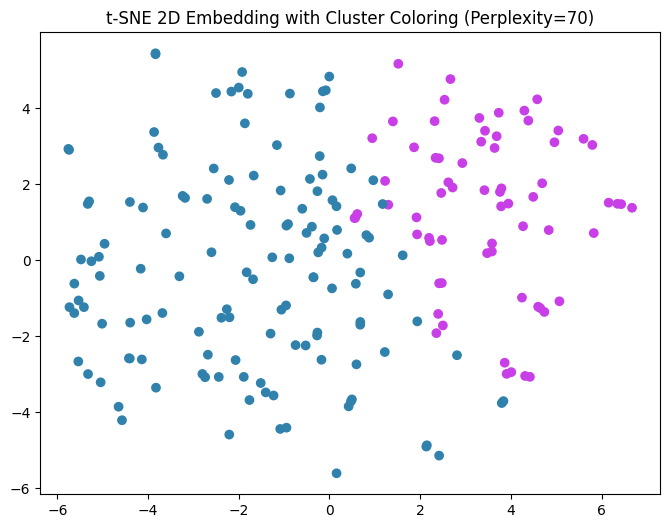

In [13]:
from active_learning_utils import visualize_and_return_indices

all_indices,_ = visualize_and_return_indices(X_embedded_2d, cluster_labels, merged_dict,
                                   x1=100,y1=100,x2=None,y2=None,selected_indices=None)

In [14]:
class_0_indices = np.where(cluster_labels == 0)[0]
class_1_indices = np.where(cluster_labels == 1)[0]
# class_2_indices = np.where(cluster_labels == 2)[0]
print(0 in cluster_labels[class_1_indices])
print(1 in cluster_labels[class_0_indices])
# print(1 in cluster_labels[class_2_indices])

False
False


filtered_indices 200
selected_indices 132
filtered_embeddings.shape (132, 2)
filtered_indices 200
selected_indices 68
filtered_embeddings.shape (68, 2)


<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

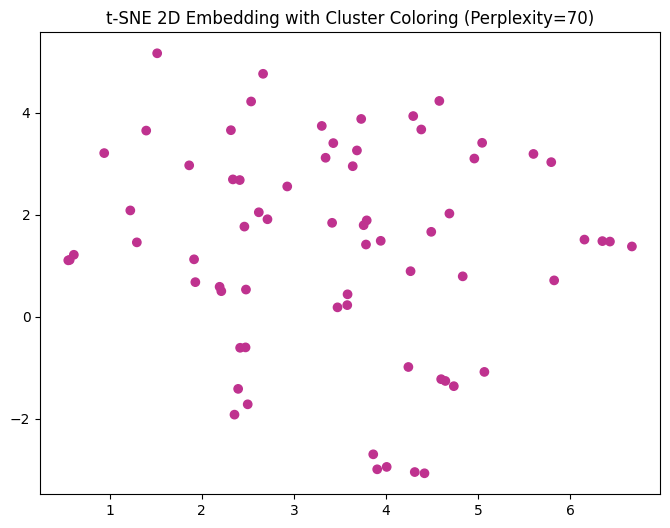

In [15]:
class_0_indices,class_0_names_filtered = visualize_and_return_indices(
    X_embedded_2d, cluster_labels, merged_dict,
    selected_indices=class_0_indices)
class_1_indices, class_1_names_filtered = visualize_and_return_indices(X_embedded_2d, 
                                                                        cluster_labels, merged_dict,
                                                                        x1=100,y1=100,x2=None,y2=None,selected_indices=class_1_indices)
# class_2_indices, class_2_names_filtered = visualize_and_return_indices(X_embedded_2d, 
#                                                                         cluster_labels, embeddings_dict,
#                                                                         x1=100,y1=100,x2=None,y2=None,selected_indices=class_2_indices)
# #可视化
#采样点的位置 平均聚类的位置


In [17]:
class_1_names_filtered

['EXACT09_CASE02_52.nii.gz',
 'EXACT09_CASE02_54.nii.gz',
 'EXACT09_CASE02_55.nii.gz',
 'EXACT09_CASE02_58.nii.gz',
 'EXACT09_CASE02_66.nii.gz',
 'EXACT09_CASE02_70.nii.gz',
 'EXACT09_CASE02_71.nii.gz',
 'EXACT09_CASE02_77.nii.gz',
 'EXACT09_CASE01_33.nii.gz',
 'EXACT09_CASE01_34.nii.gz',
 'EXACT09_CASE03_1.nii.gz',
 'EXACT09_CASE01_36.nii.gz',
 'EXACT09_CASE01_37.nii.gz',
 'EXACT09_CASE01_38.nii.gz',
 'EXACT09_CASE03_5.nii.gz',
 'EXACT09_CASE03_6.nii.gz',
 'EXACT09_CASE03_7.nii.gz',
 'EXACT09_CASE01_42.nii.gz',
 'EXACT09_CASE03_8.nii.gz',
 'EXACT09_CASE01_44.nii.gz',
 'EXACT09_CASE03_11.nii.gz',
 'EXACT09_CASE01_46.nii.gz',
 'EXACT09_CASE03_12.nii.gz',
 'EXACT09_CASE03_14.nii.gz',
 'EXACT09_CASE03_15.nii.gz',
 'EXACT09_CASE01_50.nii.gz',
 'EXACT09_CASE01_51.nii.gz',
 'EXACT09_CASE01_52.nii.gz',
 'EXACT09_CASE03_20.nii.gz',
 'EXACT09_CASE03_22.nii.gz',
 'EXACT09_CASE01_55.nii.gz',
 'EXACT09_CASE03_23.nii.gz',
 'EXACT09_CASE03_24.nii.gz',
 'EXACT09_CASE03_26.nii.gz',
 'EXACT09_CASE01_59

In [18]:
# class_0_indices
count=0
for i in class_0_indices:
    if i<1184:
        count+=1
count/len(class_0_indices),len(raw_case_name_list)/4000

(0.33880597014925373, 0.296)